In [1]:
import os
import json
import math
import time
import numpy as np
import scipy.linalg

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm
import cv2

from tqdm import tqdm
import timm
import albumentations as A
from PIL import Image
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torchvision import transforms



/tmp/ipykernel_2832242/3863176072.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [2]:
!gpustat

SJP-DIT400TR-55L     Sat Apr 13 11:20:29 2024  545.23.08
[0] Quadro RTX 8000  | 86'C, 100 % | 26452 / 49152 MB | rishit(6670M) aritra(7062M) aritra(7412M) sailaja(398M) sailaja(158M) sailaja(73M) sailaja(15M) sailaja(15M) sailaja(15M)


In [3]:
import numpy as np

NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])

image_transforms = {
    'train': A.Compose([
        A.Rotate(limit=45, p=0.5, border_mode=cv2.BORDER_CONSTANT),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.0, rotate_limit=0, p=0.5),
        A.GaussNoise(var_limit=(5.0, 20.0), p=0.5),
        A.Normalize(mean=NORM_MEAN.tolist(), std=NORM_STD.tolist()),  # Use specified mean and std
        ToTensorV2(),
    ]),
    
    'val': A.Compose([
        A.Normalize(mean=NORM_MEAN.tolist(), std=NORM_STD.tolist()),  # Use specified mean and std
        ToTensorV2(),
    ]),
    'test': A.Compose([
        A.Normalize(mean=NORM_MEAN.tolist(), std=NORM_STD.tolist()),  # Use specified mean and std
        ToTensorV2(),
    ]),
}


In [4]:
class CustomImgFolder(Dataset):
    def __init__(self, root_dir, transform=None):
        super(CustomImgFolder, self).__init__()   # Equivalent to Dataset.__init__(self).
        self.data = []
        self.root_dir = root_dir
        self.classes = [name for name in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, name)) and not name.startswith('.')]
        self.transform = transform

        for i, name in enumerate(self.classes):
            all_files = os.listdir(os.path.join(root_dir, name))
            for file in tqdm(all_files, desc=f"Loading {name}"):
                image = np.array(Image.open(os.path.join(root_dir, name, file)))
                self.data.append((image, i))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        image, label = self.data[i]
        if self.transform is not None:
            augs = self.transform(image=image)
            image = augs["image"]

        return image, label


In [5]:
train_folder_path = '/home/aritra/AML_Files/faces_train'
valid_folder_path = '/home/aritra/AML_Files/faces_Valid'
test_folder_path = '/home/aritra/AML_Files/faces_Test'

In [6]:
train_dataset = CustomImgFolder(root_dir=train_folder_path,transform=image_transforms['train'])

Loading Sanjib Patra : 100%|███████████████████████| 67/67 [00:00<00:00, 800.22it/s]


In [7]:
valid_dataset = CustomImgFolder(root_dir =valid_folder_path,transform=image_transforms['val'])

Loading Sanjib Patra : 100%|███████████████████████| 21/21 [00:00<00:00, 868.66it/s]


In [8]:
test_dataset = CustomImgFolder(root_dir =test_folder_path,transform=image_transforms['test'])

Loading Sanjib Patra : 100%|█████████████████████████| 8/8 [00:00<00:00, 882.20it/s]


In [9]:
train_dataset.classes

['Virat',
 'Abhishek Kumar ',
 'Rahul_12310890',
 'Mallikarjun',
 'Aryan Kumar',
 'Amitabh Bachchan',
 'Alia',
 'kareena_kapoor',
 'harshit kumar',
 'Anumula Chaitanya Sai',
 'Aditya_Sharma_12140070',
 'Aakash',
 'Animesh Singh',
 'Nayanthara',
 'Aritra',
 'rashmika_mandanna',
 'Prarabdh',
 'Adah_sharma',
 'Vaibhav_Arora',
 'Vishesh_Thakur',
 'Uplab Rajak',
 'Mohit Agarwala',
 'tanmoy',
 'Deepika',
 'Amogh',
 'Kishan',
 'Sanjib Patra ']

In [10]:
batch_size = 32  # Example batch size, you may have used a different value

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
valid_loader = DataLoader(valid_dataset, batch_size=10, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [12]:
class BasicBlock(nn.Module):
    
    expansion = 1
    def __init__(self,in_channels,out_channels,indentity_downsample = None, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,stride =stride,padding =1 , bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,stride = 1,padding =1 , bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.indentity_downsample = indentity_downsample
        self.stride =  stride
        self.relu = nn.ReLU()


    def forward(self,x):
        identity = x.clone()

        x = self.conv1(x)
        x =  self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x =  self.bn2(x)

        if self.indentity_downsample is not None:
            identity = self.indentity_downsample(identity)
        # Handle dimension matching with LambdaLayer (as in option A of the first code)
        if self.stride != 1:
            padding = self.out_channels-x.shape[1]
            identity = F.pad(identity, (0, 0, 0, 0, 0, padding, 0, 0))


        x +=identity
        x = self.relu(x)
        return x






In [13]:
class ResNet(nn.Module):

    def __init__(self,BasicBlock,num_blocks,no_classes = 10):
        super(ResNet, self).__init__()
        self.in_channels = 16

        self.conv1 = nn.Conv2d(
            3, 16 , kernel_size = 3 , stride=1, padding=1 , bias = False
        )
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()

        self.layer1 = self.make_layer(BasicBlock, 16, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(BasicBlock, 32, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(BasicBlock, 64, num_blocks[2], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(64,no_classes)


    def forward(self,x):
        x = self.conv1(x)
        x= self.bn1(x)
        x = self.relu(x)


        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)


        x = self.avgpool(x)
        x = x.reshape(x.shape[0],-1)
        x = self.fc(x)

        return x


    def make_layer(self, BasicBlock, out_channels, num_residual_blocks, stride):
            layers = []

            if stride != 1 or self.in_channels != out_channels * BasicBlock.expansion:
                identity_downsample = nn.Sequential(
                    nn.Conv2d(self.in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(out_channels * BasicBlock.expansion)
                )
            else:
                identity_downsample = None

            layers.append(BasicBlock(self.in_channels, out_channels, identity_downsample, stride))
            self.in_channels = out_channels * BasicBlock.expansion

            for i in range(num_residual_blocks - 1):
                layers.append(BasicBlock(self.in_channels, out_channels))

            return nn.Sequential(*layers)








In [14]:
def ResNet56(num_classes):
    return ResNet(BasicBlock, [9,9,9], num_classes)


In [15]:
model_saved_path = "/home/aritra/AML_Files/Models/resnet56_3.pth"


In [16]:
model= ResNet56(27)
model.load_state_dict(torch.load(model_saved_path))

<All keys matched successfully>

In [17]:
def calculate_test_accuracy(model):
    correct = 0
    test_samples = len(test_loader.dataset)

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Make predictions.
            prediction = model(inputs)

            # Retrieve predictions indexes.
            _, predicted_class = torch.max(prediction.data, 1)

            # Compute the number of correct predictions.
            correct += (predicted_class == labels).float().sum().item()

    test_accuracy = correct / test_samples
    return test_accuracy

In [18]:
model.eval().cuda()
accuracy = calculate_test_accuracy(model)
accuracy

0.7983193277310925

In [19]:
def show_prediction(img, label, pred, class_names= train_dataset.classes, K=5, adv_img=None, noise=None, mean=NORM_MEAN, std=NORM_STD):

    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()

        # Denormalize the image
        img = img * std + mean
        img = np.clip(img, 0.0, 1.0)

        label = label.item()

    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10, 2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12, 2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})

    ax[0].imshow(img)
    ax[0].set_title(class_names[label])
    ax[0].axis('off')

    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = adv_img * std + mean
        adv_img = np.clip(adv_img, 0.0, 1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5  # Revert normalization
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')

    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i] != label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([class_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')

    plt.show()
    plt.close()


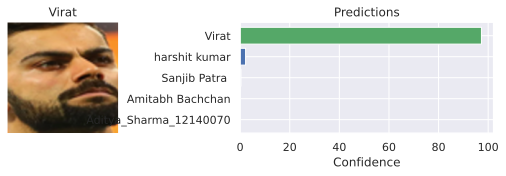

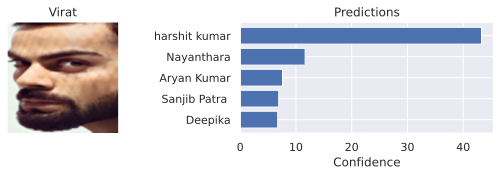

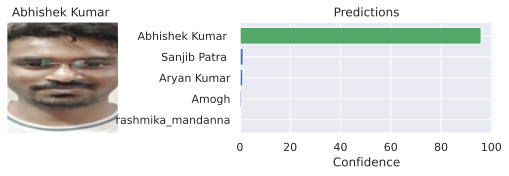

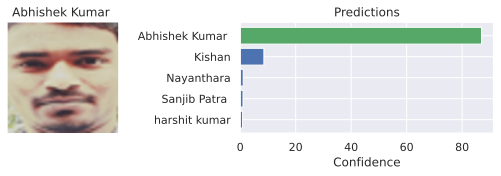

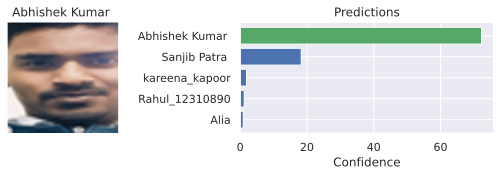

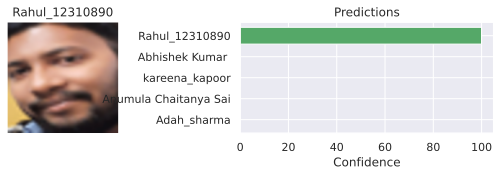

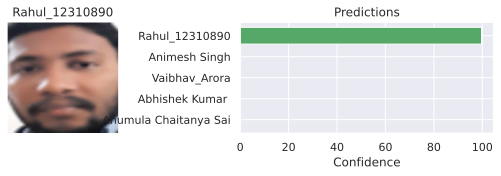

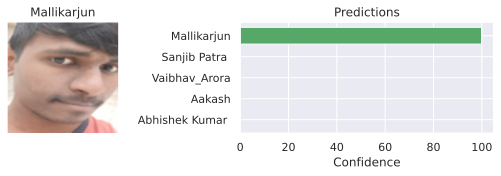

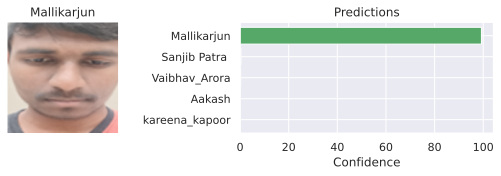

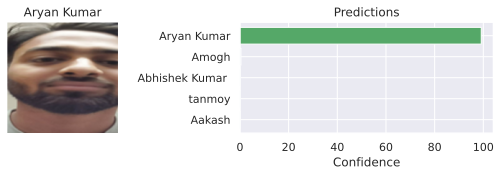

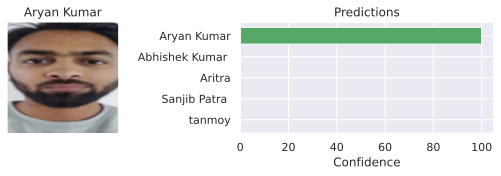

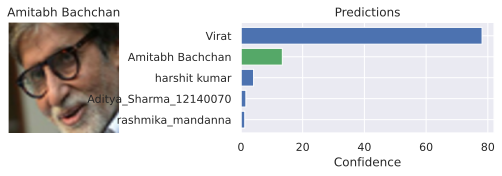

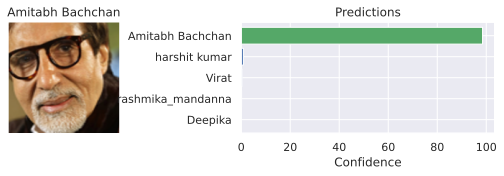

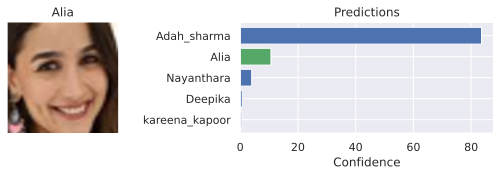

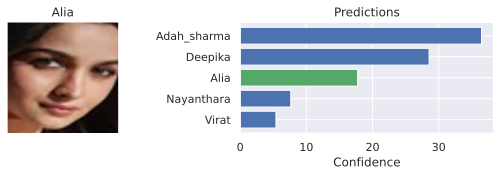

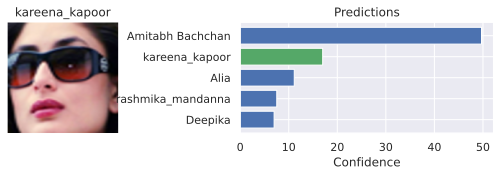

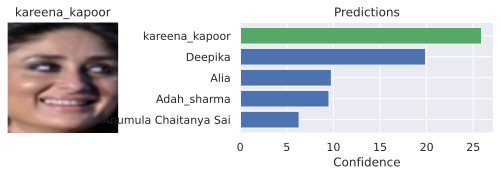

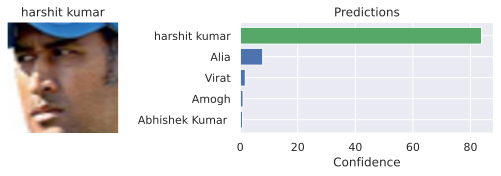

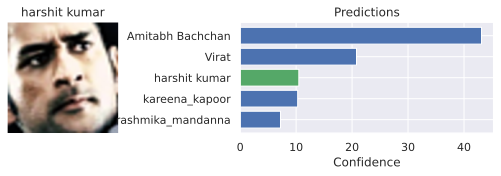

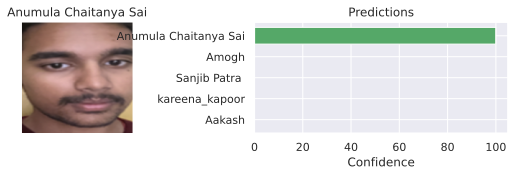

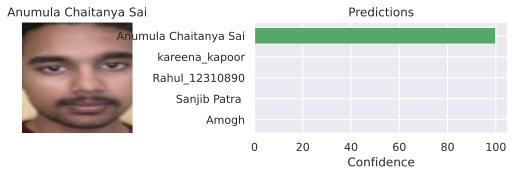

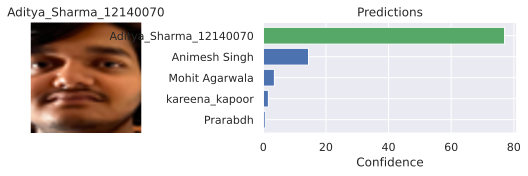

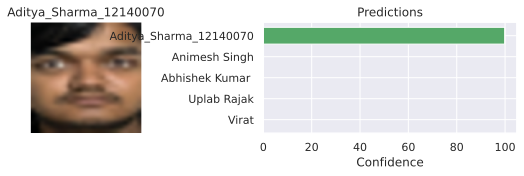

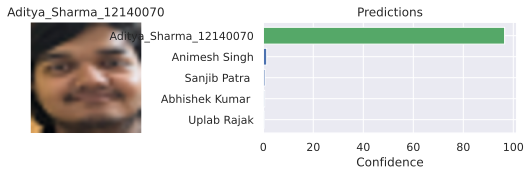

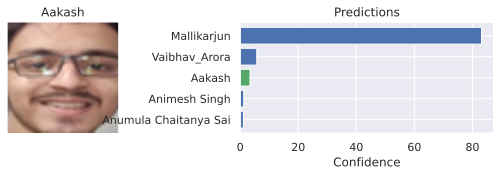

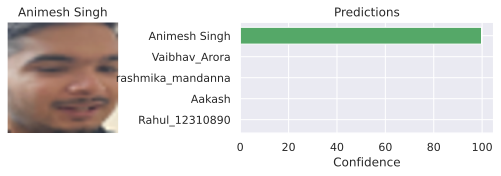

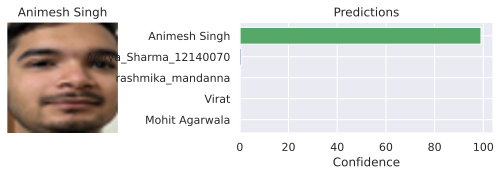

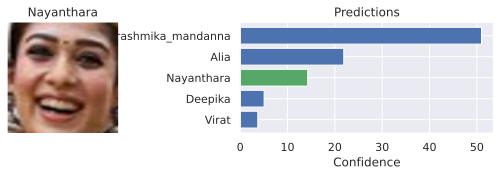

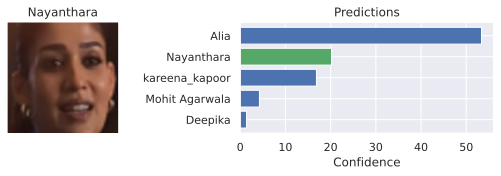

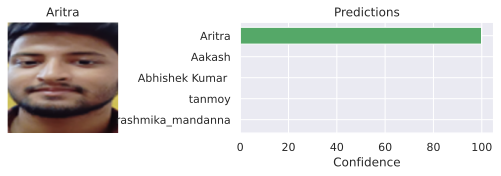

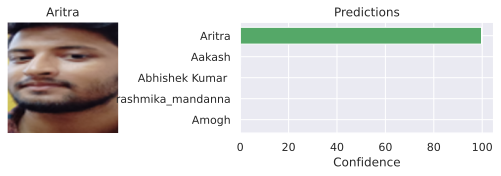

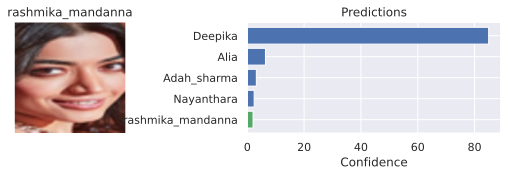

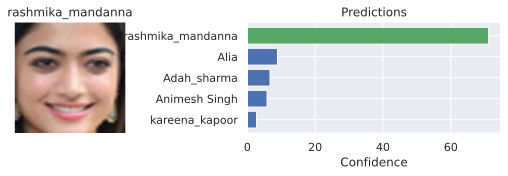

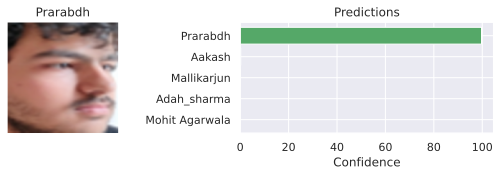

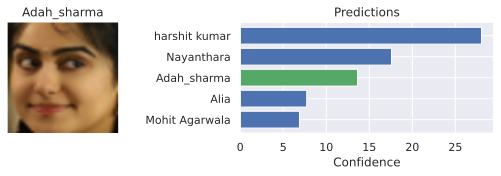

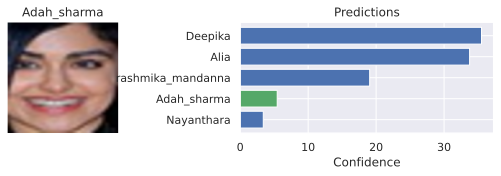

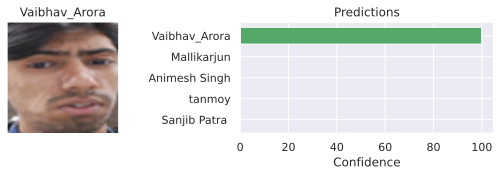

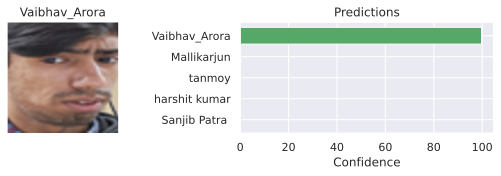

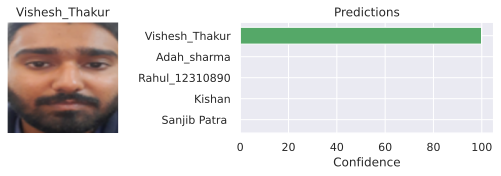

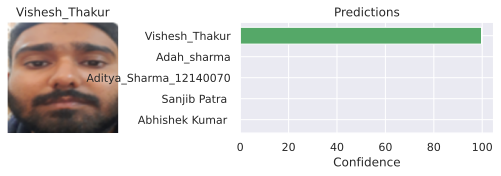

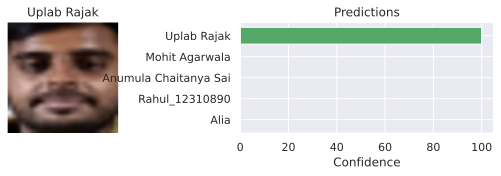

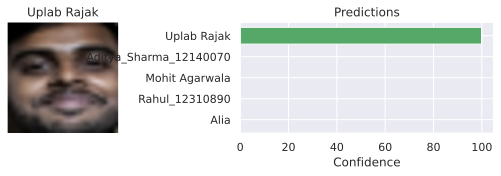

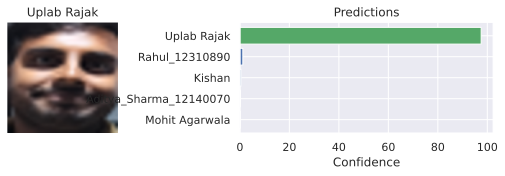

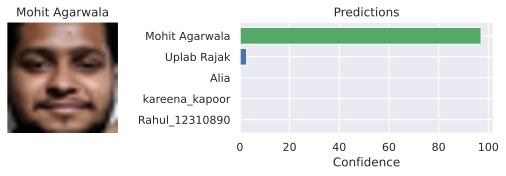

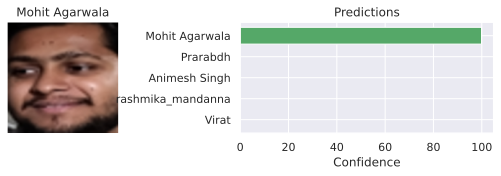

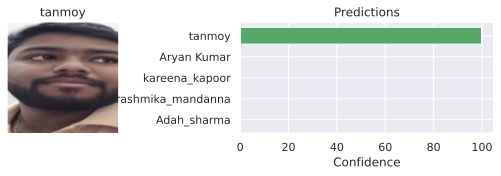

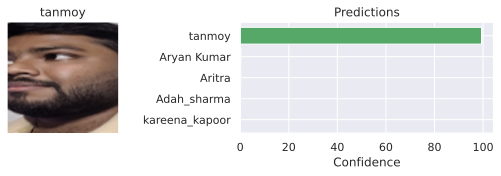

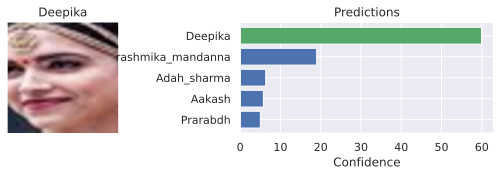

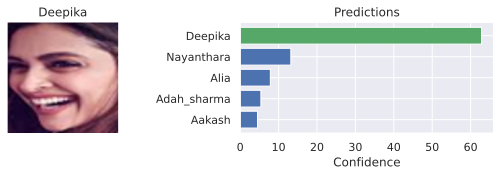

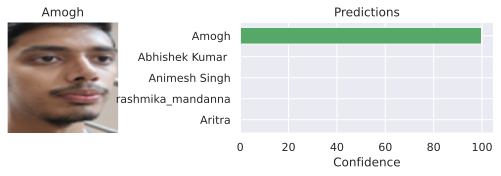

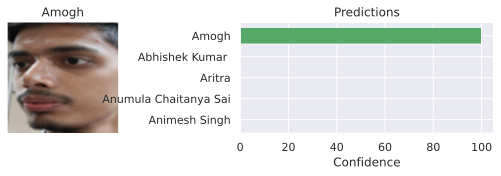

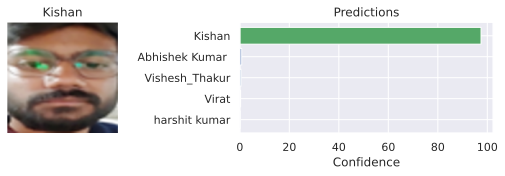

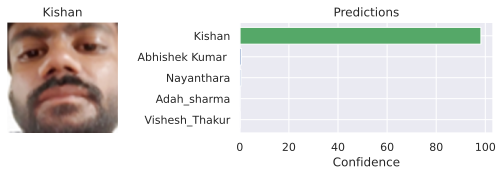

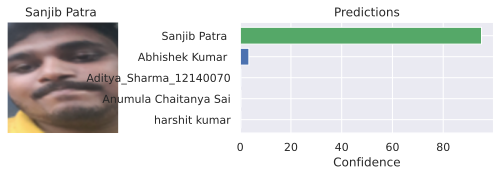

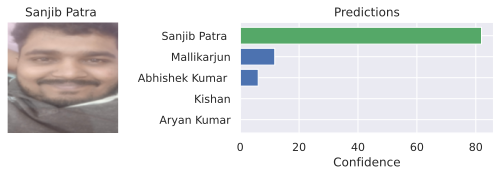

In [20]:
import torch

# Assuming you have already defined the show_prediction function here

def evaluate_model(valid_loader, model, class_names):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            for i in range(len(images)):
                img = images[i]
                lbl = labels[i]
                pred = outputs[i]

                # Call the show_prediction function here
                show_prediction(img, lbl, pred, class_names)
                break


# Call the evaluate_model function with your valid_loader, model, and class names
evaluate_model(valid_loader, model, train_dataset.classes)


In [21]:
def eval_model(dataset_loader, device, pretrained_model, img_func=None):
    tp, tp_5, counter = 0., 0., 0.
    for imgs, labels in tqdm(dataset_loader, desc="Validating..."):
        imgs = imgs.to(device)
        labels = labels.to(device)
        if img_func is not None:
            imgs = img_func(imgs)
        with torch.no_grad():
            preds = pretrained_model(imgs)
        tp += (preds.argmax(dim=-1) == labels).sum()
        tp_5 += (preds.topk(5, dim=-1)[1] == labels[...,None]).any(dim=-1).sum()
        counter += preds.shape[0]
    acc = tp.float().item() / counter
    top5 = tp_5.float().item() / counter
    print(f"Top-1 error: {(100.0 * (1 - acc)):4.2f}%")
    print(f"Top-5 error: {(100.0 * (1 - top5)):4.2f}%")
    return acc, top5


In [22]:
acc, top5 = eval_model(valid_loader, device, model)
acc , top5

Validating...: 100%|████████████████████████████████| 55/55 [00:02<00:00, 22.64it/s]

Top-1 error: 20.51%
Top-5 error: 3.66%


(0.7948717948717948, 0.9633699633699634)

In [23]:
def place_patch(img, patch):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
        img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return img

In [24]:
TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:, None, None], torch.FloatTensor(NORM_STD)[:, None, None]
def patch_forward(patch):
    # Map patch values from [-infty,infty] to ImageNet min and max
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

In [36]:
def eval_patch(model, patch, val_loader, device=device):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # For stability, place the patch at 4 random locations per image, and average the performance
            for _ in range(4):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                # Calculate accuracy excluding the images where the model predicts the target class
                tp += (pred.argmax(dim=-1) != img_labels).sum()
                tp_5 += (pred.topk(5, dim=-1)[1] != img_labels.unsqueeze(1)).any(dim=-1).sum()
                counter += img_labels.size(0)
    acc = tp.float() / counter
    top5 = tp_5.float() / counter
    return acc, top5


In [87]:
def patch_attack(model, train_loader, valid_loader, patch_size=32, num_epochs=5):
    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_patch(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = torch.argmax(pred, dim=1)
            loss = loss_module(pred, labels)
#             optimizer.zero_grad()
            (-loss).mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")

    # Final validation
    acc, top5 = eval_patch(model, patch, valid_loader)

    return patch.data, {"acc": acc.item(), "top5": top5.item()}


In [88]:
import os
import json

CHECKPOINT_PATH = "/home/aritra/AML_Files/Check_Points/"

In [89]:
# If you train new patches, you can save the results via calling this function
def save_results(patch_dict):
    result_dict = {psize: [t.item() if isinstance(t, torch.Tensor) else t
                           for t in patch_dict[psize]["results"]]
                   for psize in patch_dict}
    with open(os.path.join(CHECKPOINT_PATH, "patch_results.json"), "w") as f:
        json.dump(result_dict, f, indent=4)


In [90]:
# Load evaluation results of the pretrained patches
json_results_file = os.path.join(CHECKPOINT_PATH, "patch_results.json")
json_results = {}
if os.path.isfile(json_results_file):
    with open(json_results_file, "r") as f:
        json_results = json.load(f)


In [91]:
import os
import torch

def get_patches(patch_sizes, pretrained_model, train_loader, valid_loader, json_results, CHECKPOINT_PATH, device):
    result_dict = {}

    # Loop over all patch sizes
    for patch_size in patch_sizes:
        result_dict[patch_size] = {}  # No need for class-specific results

        file_name = os.path.join(CHECKPOINT_PATH, f"{patch_size}_patch.pt")

        # Load or train patch for each patch size
        if not os.path.isfile(file_name):
            patch, val_results = patch_attack(pretrained_model, train_loader, valid_loader, patch_size=patch_size, num_epochs=10)
            print(f"Validation results for {patch_size}:", val_results)
            torch.save(patch, file_name)
        else:
            patch = torch.load(file_name)

        # Load evaluation results if exist, otherwise manually evaluate the patch
        if str(patch_size) in json_results:
            results = json_results[str(patch_size)]
        else:
            results = eval_patch(pretrained_model, patch, valid_loader)

        # Store results and the patches in a dict for better access
        result_dict[patch_size] = {
            "results": results,
            "patch": patch
        }

    return result_dict


In [92]:
patch_sizes = [32, 48]
# Call the get_patches function
patch_dict = get_patches(patch_sizes, model, train_loader, valid_loader, json_results, CHECKPOINT_PATH, device)


Validation results for 32: {'acc': 0.7948718070983887, 'top5': 1.0}


Validation results for 48: {'acc': 0.7893772721290588, 'top5': 1.0}


In [68]:
def show_patches():
    fig, ax = plt.subplots(1, len(patch_sizes), figsize=(len(patch_sizes)*2.2, 2.2))
    for p_idx, psize in enumerate(patch_sizes):
        patch = patch_dict[psize]["patch"]
        patch = (torch.tanh(patch) + 1) / 2  # Parameter to pixel values
        patch = patch.cpu().permute(1, 2, 0).numpy()
        patch = np.clip(patch, a_min=0.0, a_max=1.0)
        ax[p_idx].imshow(patch)
        ax[p_idx].set_title(f"Patch Size: {psize}")
        ax[p_idx].axis('off')
    plt.show()


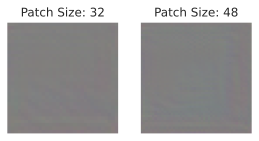

In [69]:
show_patches()

In [70]:
%%html
<!-- Some HTML code to increase font size in the following table -->
<style>
th {font-size: 120%;}
td {font-size: 120%;}
</style>

In [71]:
import tabulate
from IPython.display import display, HTML

def show_table(top_1=True):
    i = 0 if top_1 else 1
    table = [[name] + [f"{(100.0 * patch_dict[psize]['results'][i]):4.2f}%" for psize in patch_sizes]
             for name in class_names]
    display(HTML(tabulate.tabulate(table, tablefmt='html', headers=["Patch size"] + ["Accuracy" for _ in patch_sizes])))

show_table(top_1=True)


In [72]:
def perform_patch_attack(patch):
    patch_batch = exmp_batch.clone()
    patch_batch = place_patch(patch_batch, patch)
    with torch.no_grad():
        patch_preds = model(patch_batch.to(device))
    for i in range(1,17,5):
        show_prediction(patch_batch[i], label_batch[i], patch_preds[i])

In [73]:
exmp_batch , label_batch = next(iter(train_loader))

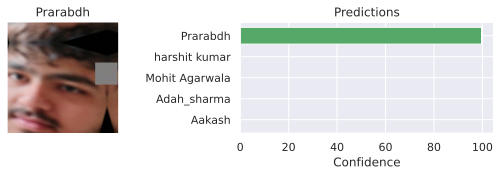

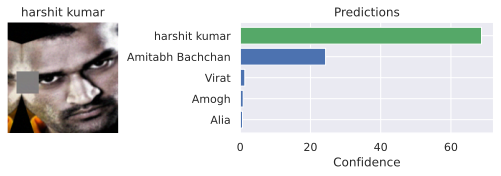

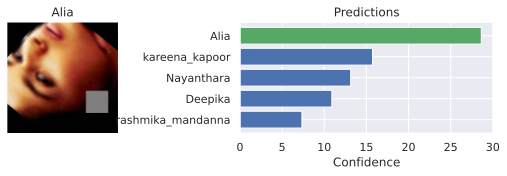

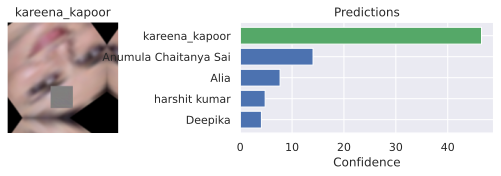

In [74]:
perform_patch_attack(patch_dict[32]['patch'])